# Recommender Systems 2020/21

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

Let's use the DataReader provided with the course repo

In [2]:
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [3]:
dataReader = Movielens10MReader()
dataset = dataReader.load_data()

URM_all = dataset.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: <class 'Data_manager.Dataset.Dataset'>
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10217, feature occurrences: 108563, density 9.95E-04
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10237, feature occurrences: 130127, density 1.19E-03




# Item-based Collaborative Filtering

In [4]:
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
import numpy as np

class ItemKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [5]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 6100 ( 57 % ), 201.42 column/sec, elapsed time 0.50 min
Similarity column 10681 ( 100 % ), 193.85 column/sec, elapsed time 0.92 min


#### Let's compute recommendations for a fixed group of users

In [6]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 595.20 usr/sec


## Remember to keep the URM in CSR format!

## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [7]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_dict[10]["MAP"])

ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1127.57 column/sec, elapsed time 0.16 min
EvaluatorHoldout: Processed 66000 ( 94.59% ) in 30.13 sec. Users per second: 2190
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 31.86 sec. Users per second: 2190
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1120.83 column/sec, elapsed time 0.16 min
EvaluatorHoldout: Processed 61000 ( 87.43% ) in 30.07 sec. Users per second: 2028
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 34.31 sec. Users per second: 2034
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1154.51 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 59000 ( 84.56% ) in 30.50 sec. Users per second: 1935
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 36.04 sec. Users per second: 1936
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 114

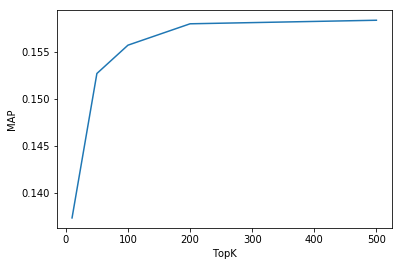

In [8]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors has a great impact on MAP.

#### Different datasets will behave in different ways.

### Shrinkage

In [9]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_dict[10]["MAP"])

ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1157.51 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 58000 ( 83.13% ) in 30.11 sec. Users per second: 1926
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 36.19 sec. Users per second: 1928
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1158.14 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 59000 ( 84.56% ) in 30.51 sec. Users per second: 1933
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 36.09 sec. Users per second: 1933
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1157.39 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 58000 ( 83.13% ) in 30.25 sec. Users per second: 1917
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 36.37 sec. Users per second: 1919
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 115

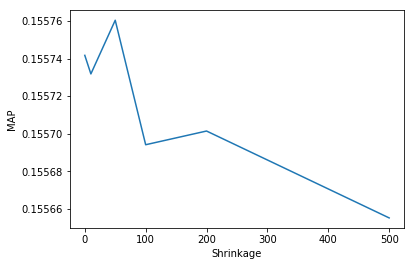

In [10]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) has no impact. Combine a parameter search with the two to ensure maximum recommendation quality

## REMINDER: Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# User-based Collaborative Filtering

In [11]:
class UserKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        
        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [12]:
recommender = UserKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10600 ( 15 % ), 351.89 column/sec, elapsed time 0.50 min
Similarity column 21300 ( 30 % ), 353.06 column/sec, elapsed time 1.01 min
Similarity column 32000 ( 46 % ), 353.45 column/sec, elapsed time 1.51 min
Similarity column 42700 ( 61 % ), 353.63 column/sec, elapsed time 2.01 min
Similarity column 53400 ( 76 % ), 353.78 column/sec, elapsed time 2.52 min
Similarity column 64100 ( 92 % ), 353.77 column/sec, elapsed time 3.02 min
Similarity column 69878 ( 100 % ), 353.75 column/sec, elapsed time 3.29 min


####  Let's compute recommendations for a fixed group of users

In [13]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 2325.45 usr/sec


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [14]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_dict[10]["MAP"])

UserKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 9854 ( 14 % ), 327.44 column/sec, elapsed time 0.50 min
Similarity column 19646 ( 28 % ), 324.32 column/sec, elapsed time 1.01 min
Similarity column 38744 ( 55 % ), 322.60 column/sec, elapsed time 2.00 min
Similarity column 58038 ( 83 % ), 323.47 column/sec, elapsed time 2.99 min
Similarity column 67921 ( 97 % ), 322.82 column/sec, elapsed time 3.51 min
Similarity column 69878 ( 100 % ), 322.44 column/sec, elapsed time 3.61 min
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 29.01 sec. Users per second: 2405
UserKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 9854 ( 14 % ), 325.77 column/sec, elapsed time 0.50 min
Similarity column 19544 ( 28 % ), 323.41 column/sec, elapsed time 1.01 min
Similarity column 38696 ( 55 % ), 322.36 column/sec, elapsed time 2.00 min
Similarity column 48350 ( 69 % ), 322.18 column/sec, elapsed time 2.50 min
Similarity column 67830 ( 97 % ), 322.25 column/se

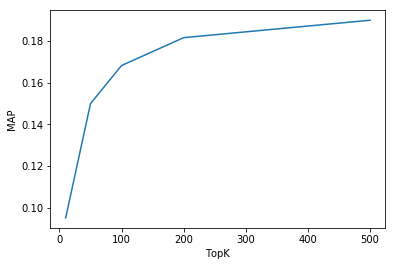

In [15]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [16]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_dict[10]["MAP"])

UserKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 9962 ( 14 % ), 332.05 column/sec, elapsed time 0.50 min
Similarity column 19922 ( 29 % ), 329.31 column/sec, elapsed time 1.01 min
Similarity column 39348 ( 56 % ), 328.12 column/sec, elapsed time 2.00 min
Similarity column 49210 ( 70 % ), 328.01 column/sec, elapsed time 2.50 min
Similarity column 59040 ( 84 % ), 327.73 column/sec, elapsed time 3.00 min
Similarity column 68817 ( 98 % ), 325.38 column/sec, elapsed time 3.52 min
Similarity column 69878 ( 100 % ), 324.62 column/sec, elapsed time 3.59 min
EvaluatorHoldout: Processed 58000 ( 83.13% ) in 30.41 sec. Users per second: 1907
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 36.57 sec. Users per second: 1908
UserKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 9565 ( 14 % ), 316.83 column/sec, elapsed time 0.50 min
Similarity column 28461 ( 41 % ), 316.44 column/sec, elapsed time 1.50 min
Similarity column 38000 ( 54 % ), 316.63 co

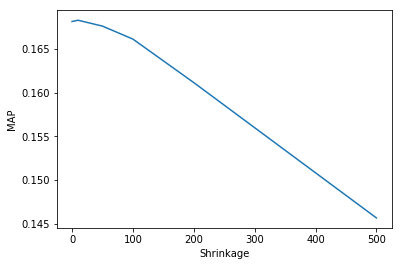

In [17]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

### Comparing different similarity heuristics

#### Let's see how different are the similarities 

In [18]:
similarity_heuristic_list = ["cosine", "dice", "jaccard", "pearson"]
similarity_dict = {}

for similarity_heuristic in similarity_heuristic_list:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=100, similarity = similarity_heuristic)
    
    similarity_dict[similarity_heuristic] = recommender.W_sparse

ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1172.38 column/sec, elapsed time 0.15 min
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1177.03 column/sec, elapsed time 0.15 min
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1146.09 column/sec, elapsed time 0.16 min
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 1138.63 column/sec, elapsed time 0.16 min


#### Let's see what is the similarity distribution

In [20]:
W_cosine = similarity_dict["cosine"]
W_cosine.tocoo()

coordinates_sorted = np.argsort(-W_cosine.data)

cosine_similarities_sorted = W_cosine.data[coordinates_sorted]
cosine_similarities_sorted

array([9.9999994e-01, 9.9999994e-01, 9.9999994e-01, ..., 1.6608225e-03,
       1.6357736e-03, 9.4998727e-04], dtype=float32)

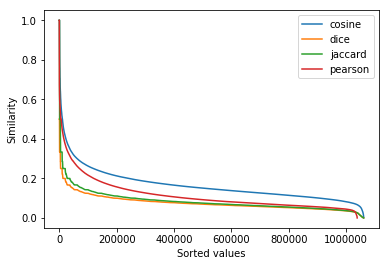

In [21]:
for similarity_heuristic in similarity_heuristic_list:
    W_sparse = similarity_dict[similarity_heuristic]
    
    pyplot.plot(-np.sort(-W_sparse.data), label=similarity_heuristic)
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

In [22]:
W_cosine = similarity_dict["cosine"]
W_cosine.nonzero()

(array([    0,     0,     0, ..., 10676, 10676, 10676], dtype=int32),
 array([   12,   128,   310, ...,  7510,  8598, 10419], dtype=int32))

In [23]:
cosine_sorted_coordinates = np.argsort(-np.array(W_cosine[W_cosine.nonzero()]).ravel())
cosine_sorted_coordinates

array([1027041,  886776, 1025477, ...,  198874,    1224,   38926],
      dtype=int64)

In [24]:
W_sparse = similarity_dict["cosine"]
similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
similarity_values[cosine_sorted_coordinates]

array([9.9999994e-01, 9.9999994e-01, 9.9999994e-01, ..., 1.6608225e-03,
       1.6357736e-03, 9.4998727e-04], dtype=float32)

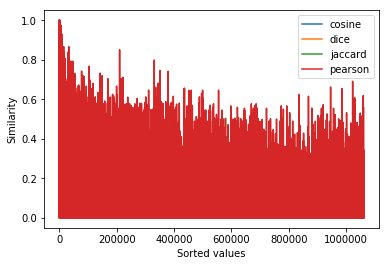

In [25]:
for similarity_heuristic in similarity_heuristic_list:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates], label=similarity_heuristic)
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

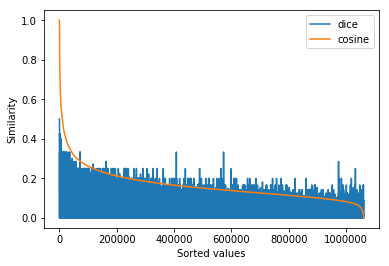

In [26]:
for similarity_heuristic in ["dice", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates], label=similarity_heuristic)
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

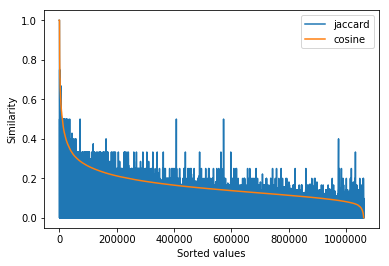

In [27]:
for similarity_heuristic in ["jaccard", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates], label=similarity_heuristic)
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

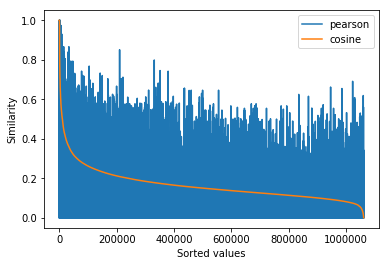

In [28]:
for similarity_heuristic in ["pearson", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates], label=similarity_heuristic)
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

## Comparing CF and CBF item-based KNNs

In [29]:
ICM_all = dataset.get_loaded_ICM_dict()["ICM_all"]
ICM_all

<10681x10237 sparse matrix of type '<class 'numpy.float64'>'
	with 130127 stored elements in Compressed Sparse Row format>

### Rewrite the content-based recommender

In [30]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

content_recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
content_MAP = []

collaborative_recommender = ItemKNNCFRecommender(URM_train)
collaborative_MAP = []

x_tick = []

for topK in [50, 100, 200]:
    for shrink in [10, 50, 100]:
        
        x_tick.append("topk {}, shrink {}".format(topK, shrink))
        
        content_recommender.fit(shrink=shrink, topK=topK)
        collaborative_recommender.fit(shrink=shrink, topK=topK)
        
        result_dict, _ = evaluator_test.evaluateRecommender(content_recommender)
        content_MAP.append(result_dict[10]["MAP"])
        
        result_dict, _ = evaluator_test.evaluateRecommender(collaborative_recommender)
        collaborative_MAP.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 60 (0.56 %) cold items.
ItemKNNCFRecommender: URM Detected 60 (0.56 %) cold items.
Similarity column 10681 ( 100 % ), 6220.38 column/sec, elapsed time 0.03 min
Similarity column 10681 ( 100 % ), 1159.78 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 62000 ( 88.86% ) in 30.12 sec. Users per second: 2058
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 33.90 sec. Users per second: 2058
EvaluatorHoldout: Processed 60000 ( 85.99% ) in 30.43 sec. Users per second: 1971
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 35.24 sec. Users per second: 1980
Similarity column 10681 ( 100 % ), 6242.19 column/sec, elapsed time 0.03 min
Similarity column 10681 ( 100 % ), 1133.08 column/sec, elapsed time 0.16 min
EvaluatorHoldout: Processed 57000 ( 81.69% ) in 30.43 sec. Users per second: 1873
EvaluatorHoldout: Processed 69774 ( 100.00% ) in 37.27 sec. Users per second: 1872
EvaluatorHoldout: Processed 61000 ( 87.43% ) in 30.40 sec. Users per second: 2

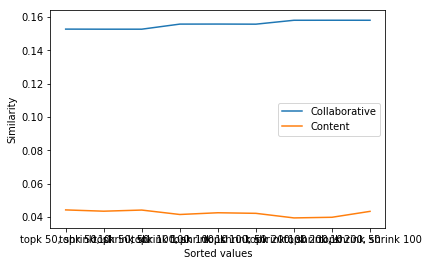

In [31]:
pyplot.plot(x_tick, collaborative_MAP, label="Collaborative")
pyplot.plot(x_tick, content_MAP, label="Content")   

pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

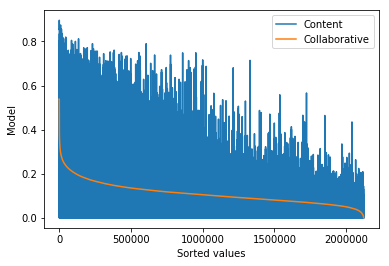

In [32]:
W_collaborative = collaborative_recommender.W_sparse
W_content = content_recommender.W_sparse
    
# Sort similarities according to cosine
collaborative_similarity_values = np.array(W_collaborative[W_collaborative.nonzero()]).ravel()
content_similarity_values = np.array(W_content[W_collaborative.nonzero()]).ravel()

sorted_args = np.argsort(-collaborative_similarity_values)

pyplot.plot(content_similarity_values[sorted_args], label="Content")
pyplot.plot(collaborative_similarity_values[sorted_args], label="Collaborative")
    
pyplot.ylabel('Model')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

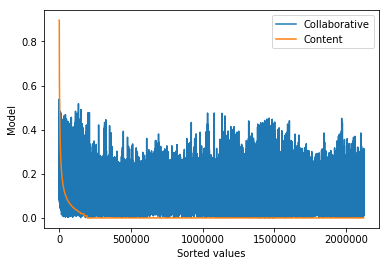

In [33]:
sorted_args = np.argsort(-content_similarity_values)

pyplot.plot(collaborative_similarity_values[sorted_args], label="Collaborative")
pyplot.plot(content_similarity_values[sorted_args], label="Content")
    
pyplot.ylabel('Model')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

## Collaborative is outperforming content-based by a large margin, as we could expect

### Let's try to see how the recommendations are distributed

In [34]:
x_tick = np.arange(URM_all.shape[1])
counter_content = np.zeros(URM_all.shape[1])
counter_collaborative = np.zeros(URM_all.shape[1])

for user_id in range(URM_all.shape[0]):
    recs = collaborative_recommender.recommend(user_id)[:10]
    counter_collaborative[recs] += 1
    
    recs = content_recommender.recommend(user_id)[:10]
    counter_content[recs] += 1
    
    if user_id % 10000 == 0:
        print("Recommended to user {}/{}".format(user_id, URM_all.shape[0]))

Recommended to user 0/69878
Recommended to user 10000/69878
Recommended to user 20000/69878
Recommended to user 30000/69878
Recommended to user 40000/69878
Recommended to user 50000/69878
Recommended to user 60000/69878


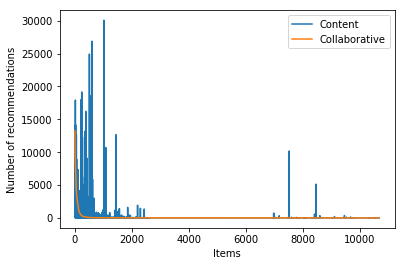

In [35]:
sorted_items = np.argsort(-counter_collaborative)
       
pyplot.plot(x_tick, counter_content[sorted_items], label = "Content")
pyplot.plot(x_tick, counter_collaborative[sorted_items], label = "Collaborative")

pyplot.ylabel('Number of recommendations')
pyplot.xlabel('Items')
pyplot.legend()
pyplot.show()

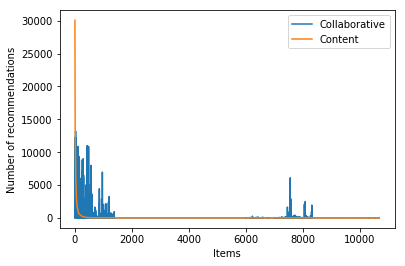

In [36]:
sorted_items = np.argsort(-counter_content)

pyplot.plot(x_tick, counter_collaborative[sorted_items], label = "Collaborative")
pyplot.plot(x_tick, counter_content[sorted_items], label = "Content")

pyplot.ylabel('Number of recommendations')
pyplot.xlabel('Items')
pyplot.legend()
pyplot.show()